<a href="https://colab.research.google.com/github/justincheng101/LBNL_Internship/blob/main/PreprocessSimple.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries and Set Hyperparameters

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# for data load
import os

# for reading and processing images
import imageio
from PIL import Image

# for visualizations
from sklearn import metrics
import matplotlib.pyplot as plt

import numpy as np # for using np arrays

import random

# for bulding and running deep learning model
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K
from keras.models import Sequential
from tensorflow.keras.layers import Activation, Flatten, Dense, Input, Conv2D, Convolution2D, MaxPooling2D, Dropout, BatchNormalization, Conv2DTranspose, RandomCrop, RandomFlip, RandomRotation, concatenate, Concatenate, UpSampling2D, Layer
from tensorflow.keras.losses import binary_crossentropy
from sklearn.model_selection import train_test_split

# Define the desired size
size = 1024
# How many transformations of each image
augmentation = 20

# Load and Preprocess Data

In [ ]:
def LoadData (path1, path2):
    """
    Looks for relevant filenames in the shared path
    Returns 2 lists for original and masked files respectively
    
    """
    # Read the images folder like a list
    image_dataset = os.listdir(path1)
    mask_dataset = os.listdir(path2)

    # Make a list for images and masks filenames
    orig_img = []
    mask_img = []
    for file in image_dataset:
        orig_img.append(file)
    for file in mask_dataset:
        mask_img.append(file)

    # Sort the lists to get both of them in same order (the dataset has exactly the same name for images and corresponding masks)
    orig_img.sort()
    mask_img.sort()
    
    return orig_img, mask_img

In [ ]:
def PreprocessData(img, mask, target_shape_img, target_shape_mask, path1, path2):
    """
    Processes the images and mask present in the shared list and path
    Returns a NumPy dataset with images as 3-D arrays of desired size
    Please note the masks in this dataset have only one channel
    """
    # Pull the relevant dimensions for image and mask
    m = len(img)                     # number of images
    i_h,i_w,i_c = target_shape_img   # pull height, width, and channels of image
    m_h,m_w,m_c = target_shape_mask  # pull height, width, and channels of mask    
    
    # Define X and Y as number of images along with shape of one image
    X = np.zeros((m,i_h,i_w,i_c), dtype=np.float32)
    y = np.zeros((m,m_h,m_w,m_c), dtype=np.int32)
    
    # Resize images and masks
    for file in img:        
        # convert image into an array of desired shape (3 channels)
        index = img.index(file)
        path = os.path.join(path1, file)
        single_img = Image.open(path).convert('RGB')
        single_img = single_img.resize((i_h,i_w))
        single_img = np.reshape(single_img,(i_h,i_w,i_c))
        single_img = single_img/256.
        X[index] = single_img

        # convert mask into an array of desired shape (1 channel)
        single_mask_ind = mask[index]
        path = os.path.join(path2, single_mask_ind)
        single_mask = Image.open(path)
        single_mask = single_mask.resize((m_h, m_w))
        single_mask = np.reshape(single_mask,(m_h,m_w,m_c))
        single_mask = single_mask/255.
        y[index] = single_mask
    
    return X, y

(2668, 2668, 3)
(2668, 2668)


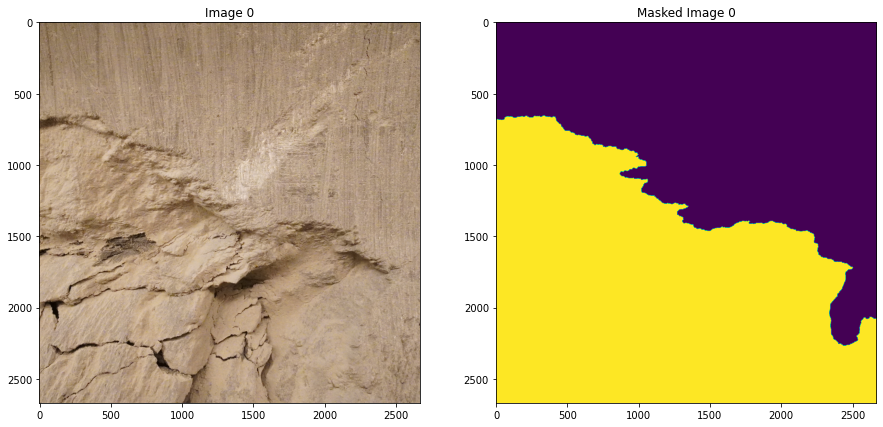

In [ ]:
""" Load Train Set and view some examples """
# Call the apt function
path1 = './drive/MyDrive/CroppedImageOriginals/'
path2 = './drive/MyDrive/CroppedImageBreakout/'
img, mask = LoadData (path1, path2)

# View an example of image and corresponding mask 
show_images = 1
img = sorted((f for f in img if not f.startswith(".")), key=str.lower)
mask = sorted((f for f in mask if not f.startswith(".")), key=str.lower)
for i in range(show_images): 
    img_view  = imageio.imread(path1 + img[i])
    mask_view = imageio.imread(path2 + mask[i])
    print(img_view.shape)
    print(mask_view.shape)
    fig, arr = plt.subplots(1, 2, figsize=(15, 15))
    arr[0].imshow(img_view)
    arr[0].set_title('Image '+ str(i))
    arr[1].imshow(mask_view)
    arr[1].set_title('Masked Image '+ str(i))

X Shape: (4, 1024, 1024, 3)
Y shape: (4, 1024, 1024, 1)
[0 1]


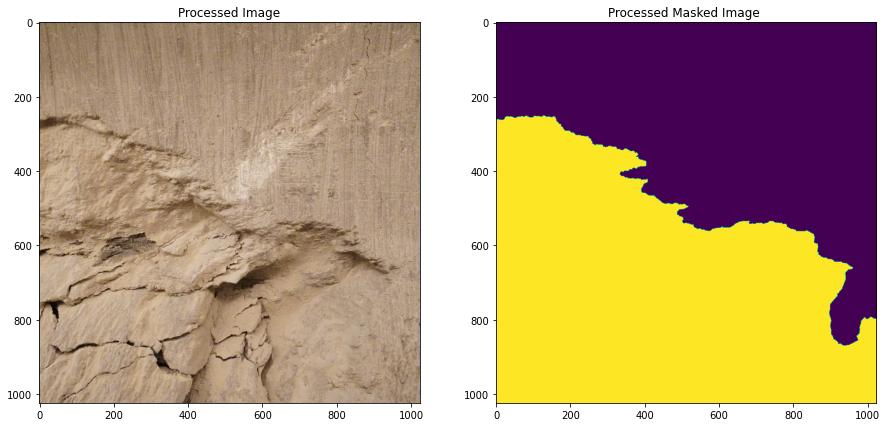

In [ ]:
# Define desired shape
target_shape_img = [size, size, 3]
target_shape_mask = [size, size, 1]

# Process data using apt helper function
X, y = PreprocessData(img, mask, target_shape_img, target_shape_mask, path1, path2)

# QC the shape of output and classes in output dataset 
print("X Shape:", X.shape)
print("Y shape:", y.shape)
# There are 3 classes : background, pet, outline
print(np.unique(y))

# Visualize the output
for image_index in range(1):
    fig, arr = plt.subplots(1, 2, figsize=(15, 15))
    arr[0].imshow(X[image_index])
    arr[0].set_title('Processed Image')
    arr[1].imshow(y[image_index,:,:,0])
    arr[1].set_title('Processed Masked Image ')

In [ ]:
def AugmentData(img, mask, target_shape_img, target_shape_mask):
    """
    Augments the data by using Keras' RandomFlip and RandomRotation layers
    to create random changes to images and masks
    """
    m = len(img)                     # number of images
    i_h,i_w,i_c = target_shape_img   # pull height, width, and channels of image
    m_h,m_w,m_c = target_shape_mask  # pull height, width, and channels of mask

    X_new = np.zeros((augmentation*m,i_h,i_w,i_c), dtype=np.float32)
    y_new = np.zeros((augmentation*m,m_h,m_w,m_c), dtype=np.int32)

    # augment the data
    for index in range(len(img)):
      for i in range(augmentation):
          # use seed so img and mask receive same transformation
          seed = random.randint(0, 100)
          single_img = img[index]
          single_img = RandomFlip(mode="horizontal_and_vertical", seed=seed)(single_img)
          single_img = RandomRotation(factor=0.2, seed=seed)(single_img)
          single_mask = mask[index]
          single_mask = RandomFlip(mode="horizontal_and_vertical", seed=seed)(single_mask)
          single_mask = RandomRotation(factor=0.2, seed=seed)(single_mask)
          X_new[index+i*m] = single_img
          y_new[index+i*m] = single_mask
          
    return np.concatenate((img, X_new)), np.concatenate((mask, y_new))

In [ ]:
X, y = AugmentData(X, y, target_shape_img, target_shape_mask)

In [ ]:
# Use scikit-learn's function to split the dataset
# Here, I have used 20% data as test/valid set
# Add random_state=# for reproducible split
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2)